In [16]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [7]:
data = r'data/all_ECB_speeches.csv'

In [4]:
df = pd.read_csv(data,sep='|')
df.head()

,date,speakers,title,subtitle,contents
0,2021-10-20,Frank Elderson,Overcoming the tragedy of the horizon: requiri...,"Keynote speech by Frank Elderson, Member of th...",SPEECH Overcoming the tragedy of the horiz...
1,2021-10-19,Fabio Panetta,“Hic sunt leones” – open research questions on...,"Speech by Fabio Panetta, Member of the Executi...",SPEECH “Hic sunt leones” – open research q...
2,2021-10-19,Frank Elderson,The role of supervisors and central banks in t...,"Keynote speech by Frank Elderson, Member of th...",SPEECH The role of supervisors and central...
3,2021-10-16,Christine Lagarde,Globalisation after the pandemic,2021 Per Jacobsson Lecture by Christine Lagard...,SPEECH Globalisation after the pandemic ...
4,2021-10-14,Christine Lagarde,IMFC Statement,"Statement by Christine Lagarde, President of t...",SPEECH IMFC Statement Statement by Chri...


In [39]:
df=df.dropna(subset=['contents'])

In [40]:
data = df.contents.tolist()

In [9]:
def preprocess(data):
    # creating a list for appending the preprocessed text
    data_list = []
    # iterating through all the text
    for text in data:
        # removing the symbols and numbers
        try:
            text = re.sub(r'[!@#$()--–,“”".%^*?:;~`0-9]', ' ', text)
            text = re.sub(r"[\([{})\]]", '', text)
            text = re.sub('\s+', ' ', text)
            # converting the text to lower case
            text = text.lower()
            # appending to data_list
            data_list.append(text)
        except TypeError as e:
            #print(e)
            #print(text)
            pass
    return data_list

<>:10: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \s
<>:10: DeprecationWarning: invalid escape sequence \s
/var/folders/1j/_340nbsn4xv0344b3mw8_gd40000gn/T/ipykernel_25000/665173935.py:10: DeprecationWarning: invalid escape sequence \s
  text = re.sub('\s+', ' ', text)


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [18]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [12]:
data_prep = preprocess(data)

/Users/jbrettl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Possible set difference at position 7
  


In [13]:
data_words = list(sent_to_words(data_prep))

print(data_words[:1])

[['speech', 'overcoming', 'the', 'tragedy', 'of', 'the', 'horizon', 'requiring', 'banks', 'to', 'translate', 'targets', 'into', 'milestones', 'keynote', 'speech', 'by', 'frank', 'elderson', 'member', 'of', 'the', 'executive', 'board', 'of', 'the', 'ecb', 'and', 'vice', 'chair', 'of', 'the', 'supervisory', 'board', 'of', 'the', 'ecb', 'at', 'the', 'financial', 'market', 'authority', 'supervisory', 'conference', 'vienna', 'october', 'introduction', 'it', 'is', 'great', 'pleasure', 'for', 'me', 'to', 'speak', 'here', 'and', 'would', 'like', 'to', 'thank', 'the', 'organisers', 'for', 'inviting', 'me', 'today', 'want', 'to', 'look', 'ahead', 'to', 'next', 'year', 'to', 'the', 'next', 'five', 'years', 'and', 'to', 'the', 'three', 'decades', 'up', 'to', 'the', 'year', 'by', 'which', 'the', 'eu', 'has', 'pledged', 'to', 'become', 'carbon', 'neutral', 'under', 'the', 'paris', 'agreement', 'thirty', 'years', 'is', 'hair', 'breadth', 'of', 'time', 'merely', 'one', 'hundred', 'and', 'fifty', 'mill

In [19]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

pprint(data_lemmatized[:1])

['speech overcome tragedy horizon require bank translate target milestone '
 'speech member vice chair board ecb financial market supervisory conference '
 'introduction great pleasure speak here would like thank organiser invite '
 'today want look ahead next year next year decade year pledge become carbon '
 'neutral agreement year hair breadth time merely millionth earth year '
 'existence brief span indeed doubt time run tackle climate environmental '
 'crisis mean bank mean time preparation over time action now bank need start '
 'think next important step risk management will require look year ahead '
 'devise intermediate target risk exposure can render fit carbon neutral '
 'economy bank can no long simply declare intention compliant must make '
 'structural change way do business make sure actually reach goal avoid build '
 'risk entire financial system let first share insight gain benchmark bank '
 'self assessment supervisory expectation will then turn just refer next '
 'im

In [20]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [21]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  7.490407874404939 %


In [23]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pprint(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [24]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -22994121.90018913
Perplexity:  1029.5233902339353
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [25]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

In [26]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -4776336.1804295005
Model Perplexity:  1056.583506883035


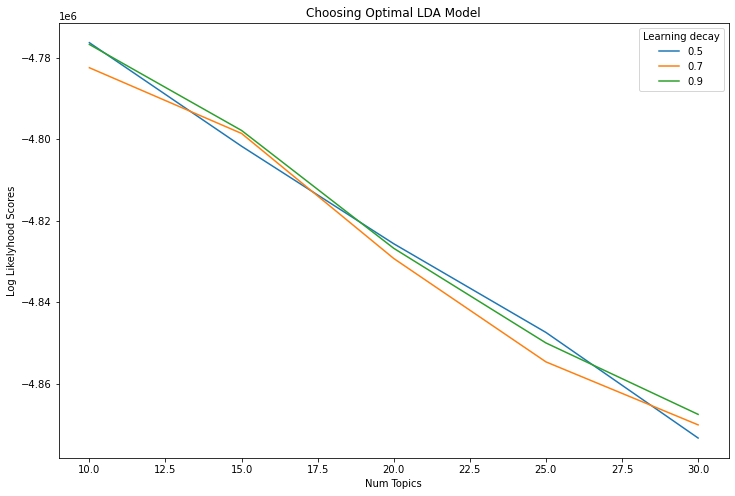

In [31]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [45]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(10)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.290000,0.150000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.270000,0.190000,0
Doc1,0.000000,0.000000,0.090000,0.010000,0.000000,0.380000,0.030000,0.000000,0.150000,0.340000,5
Doc2,0.540000,0.130000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.310000,0.010000,0
Doc3,0.070000,0.000000,0.100000,0.660000,0.000000,0.090000,0.000000,0.070000,0.010000,0.000000,3
Doc4,0.060000,0.100000,0.410000,0.140000,0.000000,0.000000,0.000000,0.080000,0.170000,0.030000,2
Doc5,0.520000,0.110000,0.000000,0.090000,0.000000,0.000000,0.000000,0.000000,0.280000,0.000000,0
Doc6,0.000000,0.030000,0.460000,0.090000,0.000000,0.000000,0.420000,0.000000,0.000000,0.000000,2
Doc7,0.000000,0.190000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.440000,0.300000,8
Doc8,0.000000,0.000000,0.470000,0.290000,0.000000,0.000000,0.240000,0.000000,0.000000,0.000000,2
Doc9,0.310000,0.000000,0.080000,0.370000,0.000000,0.040000,0.000000,0.050000,0.000000,0.140000,3


In [46]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,393
1,6,320
2,8,308
3,3,305
4,2,290
5,1,278
6,9,187
7,5,185
8,0,135
9,4,91


In [47]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  16.794341
8       0.648955  71.707100       2        1  15.203288
3      71.019684   9.971006       3        1  14.580982
7       3.785981  33.185135       4        1  13.280334
1     -42.666500  -9.222070       5        1  10.352979
2      -3.621689 -43.526516       6        1   8.867804
5      -3.632402  -4.171708       7        1   8.262977
9     -36.584400  35.804413       8        1   6.736176
0      44.391380  50.615383       9        1   4.990413
4      40.235809 -31.591665      10        1   0.930706, topic_info=             Term          Freq         Total Category  logprob  loglift
1660          die   9643.000000   9643.000000  Default  30.0000  30.0000
2500    financial  41310.000000  41310.000000  Default  29.0000  29.0000
512          bank  36794.000000  36794.000000  Default  28.0000  28.0000
3246    inflation  18353.000000  18353.000000  Default  27.0000  27.0000
5013         rate  25600.000000  25600.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
2847          gro    126.537870    149.914219  Topic10  -5.4964   4.5075
2249       europa    199.406870    540.261758  Topic10  -5.0416   3.6803
2423         fall    125.099614   2860.470682  Topic10  -5.5078   1.5474
3341  integration    129.997326   8545.616406  Topic10  -5.4694   0.4913
3246    inflation    126.553029  18353.424505  Topic10  -5.4963  -0.2999

[816 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4        10  0.986023    aber
38        1  0.028393  accede
38        3  0.005679  accede
38        7  0.914261  accede
38        9  0.045429  accede
...     ...       ...     ...
7061      3  0.036823   yield
7061      4  0.008369   yield
7061      5  0.057326   yield
7061      6  0.602972   yield
7061      7  0.055234   yield

[3089 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 4, 8, 2, 3, 6, 10, 1, 5])

/Users/jbrettl/opt/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jbrettl/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/jbrettl/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this wi

In [48]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,abandon,abate,abcp,aber,abide,ability,able,abnormal,abnormally,...,youth,yve,zeiten,zingale,zombie,zone,zuletzt,zum,zunehmend,zweiten
Topic0,0.100003,14.489579,0.100023,0.100001,0.100000,0.100040,16.263394,271.030515,0.100023,0.100034,...,9.234876,6.547161,0.1,0.100019,0.100005,78.251236,0.1,0.1,0.1,0.100000
Topic1,0.100012,4.825814,0.100017,2.059510,0.100000,0.100046,125.343910,275.500625,0.100009,0.897905,...,0.100003,3.093321,0.1,4.488693,0.100002,8.232233,0.1,0.1,0.1,0.100001
Topic2,13.640300,0.225864,0.100030,0.100005,0.100000,0.100014,56.562324,111.637724,5.625502,0.100029,...,0.100008,21.922291,0.1,0.100042,9.206805,9.657127,0.1,0.1,0.1,0.100001
Topic3,0.100009,2.469476,14.657994,0.100005,0.100000,0.100025,244.308836,151.789121,11.716435,0.100034,...,103.510094,0.210631,0.1,15.516523,22.810286,2.523564,0.1,0.1,0.1,0.100000
Topic4,0.100000,0.100001,0.100000,0.100000,94.099996,0.100000,0.100001,0.100000,0.100001,0.100002,...,0.100000,11.056488,14.1,0.100000,0.100000,1.591459,14.1,15.1,20.1,24.099991


In [49]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,banknote,euro,say,year,ecb,bank,public,climate,make,people,central,european,new,coin,think
Topic 1,financial,market,integration,risk,bank,security,central,banking,framework,institution,stability,need,important,border,level
Topic 2,rate,policy,inflation,monetary,term,purchase,bank,measure,low,market,area,condition,asset,ecb,long
Topic 3,growth,area,economic,economy,country,increase,price,policy,inflation,labour,rate,market,high,reform,low
Topic 4,die,und,fur,der,eine,sie,sind,hat,auch,geldpolitik,europa,wahrungsunion,den,banken,ist
Topic 5,area,currency,country,euro,exchange,market,international,rate,financial,policy,economic,monetary,integration,global,statistic
Topic 6,policy,monetary,price,stability,central,inflation,ecb,rate,economic,term,bank,strategy,decision,area,objective
Topic 7,area,policy,country,fiscal,crisis,economic,european,union,financial,need,market,government,national,monetary,member
Topic 8,bank,financial,risk,market,crisis,liquidity,credit,policy,asset,sector,banking,capital,area,measure,economy
Topic 9,bank,payment,banking,service,european,national,market,need,central,make,use,sepa,new,ecb,retail


In [61]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["""The Governing Council continues to judge that favourable financing conditions can be maintained with a moderately lower pace of net asset purchases under the pandemic emergency purchase programme (PEPP) than in the second and third quarters of this year.

The Governing Council also confirmed its other measures, namely the level of the key ECB interest rates, its forward guidance on their likely future evolution, its purchases under the asset purchase programme (APP), its reinvestment policies and its longer-term refinancing operations. Specifically:

Key ECB interest rates
The interest rate on the main refinancing operations and the interest rates on the marginal lending facility and the deposit facility will remain unchanged at 0.00%, 0.25% and -0.50% respectively.

In support of its symmetric two per cent inflation target and in line with its monetary policy strategy, the Governing Council expects the key ECB interest rates to remain at their present or lower levels until it sees inflation reaching two per cent well ahead of the end of its projection horizon and durably for the rest of the projection horizon, and it judges that realised progress in underlying inflation is sufficiently advanced to be consistent with inflation stabilising at two per cent over the medium term. This may also imply a transitory period in which inflation is moderately above target.

Asset purchase programme (APP)
Net purchases under the APP will continue at a monthly pace of €20 billion. The Governing Council continues to expect monthly net asset purchases under the APP to run for as long as necessary to reinforce the accommodative impact of its policy rates, and to end shortly before it starts raising the key ECB interest rates.

The Governing Council also intends to continue reinvesting, in full, the principal payments from maturing securities purchased under the APP for an extended period of time past the date when it starts raising the key ECB interest rates and, in any case, for as long as necessary to maintain favourable liquidity conditions and an ample degree of monetary accommodation.

Pandemic emergency purchase programme (PEPP)
The Governing Council will continue to conduct net asset purchases under the PEPP with a total envelope of €1,850 billion until at least the end of March 2022 and, in any case, until it judges that the coronavirus crisis phase is over.

The Governing Council continues to judge that favourable financing conditions can be maintained with a moderately lower pace of net asset purchases under the PEPP than in the second and third quarters of this year.

The Governing Council will purchase flexibly according to market conditions and with a view to preventing a tightening of financing conditions that is inconsistent with countering the downward impact of the pandemic on the projected path of inflation. In addition, the flexibility of purchases over time, across asset classes and among jurisdictions will continue to support the smooth transmission of monetary policy. If favourable financing conditions can be maintained with asset purchase flows that do not exhaust the envelope over the net purchase horizon of the PEPP, the envelope need not be used in full. Equally, the envelope can be recalibrated if required to maintain favourable financing conditions to help counter the negative pandemic shock to the path of inflation.

The Governing Council will continue to reinvest the principal payments from maturing securities purchased under the PEPP until at least the end of 2023. In any case, the future roll-off of the PEPP portfolio will be managed to avoid interference with the appropriate monetary policy stance.

Refinancing operations
The Governing Council will continue to provide ample liquidity through its refinancing operations. In particular, the third series of targeted longer-term refinancing operations (TLTRO III) remains an attractive source of funding for banks, supporting bank lending to firms and households."""]

topic, prob_scores = predict_topic(text = mytext)
print(topic)

['rate', 'policy', 'inflation', 'monetary', 'term', 'purchase', 'bank', 'measure', 'low', 'market', 'area', 'condition', 'asset', 'ecb', 'long']


In [57]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))


Component's weights: 
 [[ 0.14  0.28  0.32  0.4   0.01  0.2   0.44  0.48  0.38  0.16]
 [-0.05 -0.51  0.63  0.28  0.   -0.05  0.17 -0.16 -0.23 -0.4 ]]
Perc of Variance Explained: 
 [0.02 0.16]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

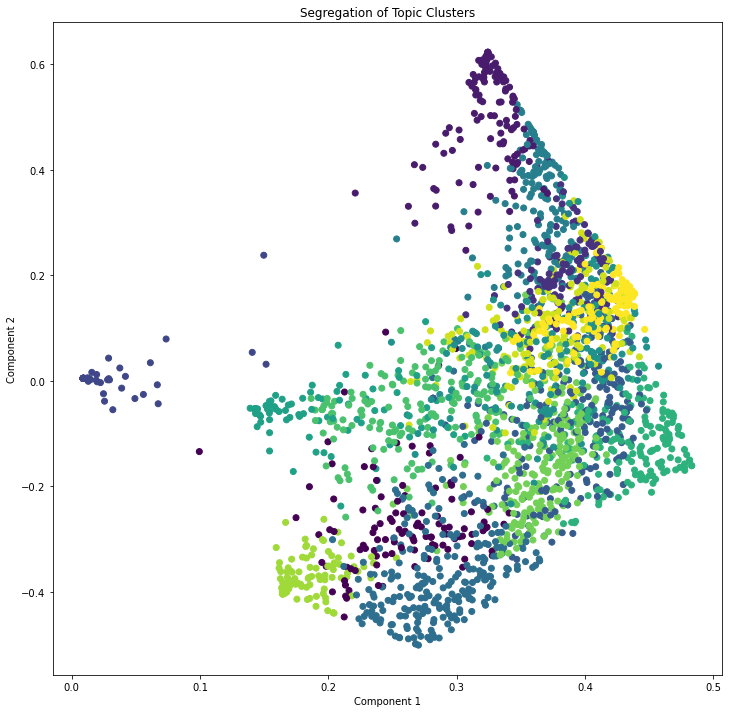

In [58]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
#plt.zlabel('Component 3')
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [59]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [62]:
# Get similar documents
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

Topic KeyWords:  ['rate', 'policy', 'inflation', 'monetary', 'term', 'purchase', 'bank', 'measure', 'low', 'market', 'area', 'condition', 'asset', 'ecb', 'long']
Topic Prob Scores of text:  [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Most Similar Doc's Probs:   [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]

   Speech on the occasion of awarding of PhD Honoris Causa to Mr. González-Parámo by the University of Malaga   Discurso pronunciado por José Manuel González-Páramo,miembro del Comité Ejecutivo del BCE, Málaga, 24 de junio de 2011 Excma. Sra. Rectora de la Universidad de Málaga, Excmo. Sr. Alcalde de Málaga, Autoridades, Excmos. e Ilmos. Miembros del Claustro, Sras y Sres.  Agradecimientos Permítanme comenzar mis palabras con una expresión de agradecimiento. Es un inmenso honor estar hoy en Málag
